In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segyio
from PIL import Image
import datetime
import cv2

#%matplotlib inline
plt.rcParams.update({'font.size': 10})

os.chdir("..")
os.chdir(os. getcwd() + "\\src")
from c import ROOT_DIR

from mseisML_utils import parse_trace_headers, parse_text_header

def make_heatmap_overlay(file_path):
    
    with segyio.open(file_path, ignore_geometry=True) as f:
        # Get basic attributes
        n_traces = f.tracecount
        sample_rate = segyio.tools.dt(f) / 1000
        n_samples = f.samples.size
        twt = f.samples
        data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
        # Load headers
        bin_headers = f.bin
        #text_headers = parse_text_header(f)
        trace_headers = parse_trace_headers(f, n_traces)
        
        f.close()
        
    f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'
    
    
    # remove noise 
    data[5:10,:] = 0
    
    clip_percentile = 99 # 99 gives most clear. 

    vm = np.percentile(data, clip_percentile)
    f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=256)

    extent = [1, n_traces, twt[-1], twt[0]]  # good extent

    #d_t = data.T
    d_t = data
    
    print('shape of data array', np.shape(d_t))
    
    c = ax.imshow(
        d_t, cmap="RdBu",
        vmin=-vm,
        vmax=vm,
        aspect='auto',
        extent=extent)

    fig.colorbar(c, ax = ax)
    ax.set_title(file_path)
    plt.show()

    print('shape of img obj: ', np.shape(c))
    print('shape of transposed data obj', np.shape(d_t))
    
    print('making array')
    save_image_path = "C:\\Users\\sauce\\OneDrive\\Desktop\\saved_segy_images\\"
    
    im = Image.fromarray((d_t))
    now = datetime.datetime.now() # current date and time

    dt = now.strftime('%m%d%Y%H%M%S')

    #os.chdir(save_image_path)

    im.save(save_image_path + dt + '.tif')
    
    # show openCV version
    
    print('open cv version')
    
    image_mat_raw = np.array(d_t, dtype = np.float64)
    
    image_mat = np.array(d_t, dtype = np.float64)
    image_mat *= (255.0/image_mat.max()) # normalize matrix
    image_mat = np.abs(image_mat)
    
    print('min', np.min(image_mat))
    print('max', np.max(image_mat))
    
    # denoise image
    fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(15,25), dpi=256)

    #dst = cv2.fastNlMeansDenoisingMulti(im_g, 2, 5, None, 4, 7, 35)
    #plt.imshow(dst)
        
    image_mat = image_mat.astype(dtype=np.uint8)
    
    #threshed = cv2.adaptiveThreshold(image_mat, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
    #median = cv2.medianBlur(threshed, 5)
    
    ax[0].imshow(image_mat_raw)
    ax[1].imshow(image_mat)
    
    #ax[2].imshow(image_mat)
    
    y_min = 250
    y_max = 700
    
    x_min = 100
    x_max = 300

    ax[2].imshow(image_mat_raw[x_min:x_max,y_min:y_max])
    #ax[3].imshow(image_mat[x_min:x_max,y_min:y_max])
    
    rescale = image_mat_raw[x_min:x_max,y_min:y_max]
    rescale = rescale.astype(dtype= np.float64)
    rescale *= (255.0/rescale.max()) # normalize matrix
    rescale = np.abs(rescale)
    rescale = rescale.astype(dtype=np.uint8)

    #ax[4].imshow(rescale)
    
    # edge detection
    
    t_lower = 20
    t_upper = 255
    
    window = image_mat[x_min:x_max,y_min:y_max]
    
    edgeG = cv2.Canny(window, t_lower, t_upper, L2gradient = True )

    sobelxy = cv2.Sobel(src=window, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
    
    ax[3].imshow(sobelxy)
    print('shape of sobelxy', np.shape(sobelxy))
    
    heatmapshow = None
    heatmapshow = cv2.normalize(sobelxy, heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
    
    ax[4].imshow(heatmapshow)
    
    # show mask 
    
    plt.show()

C:\Users\sauce\OneDrive\Desktop\mseisML\src
C:\Users\sauce\OneDrive\Desktop\mseisML\segy\ABstg06
shape of data array (300, 800)


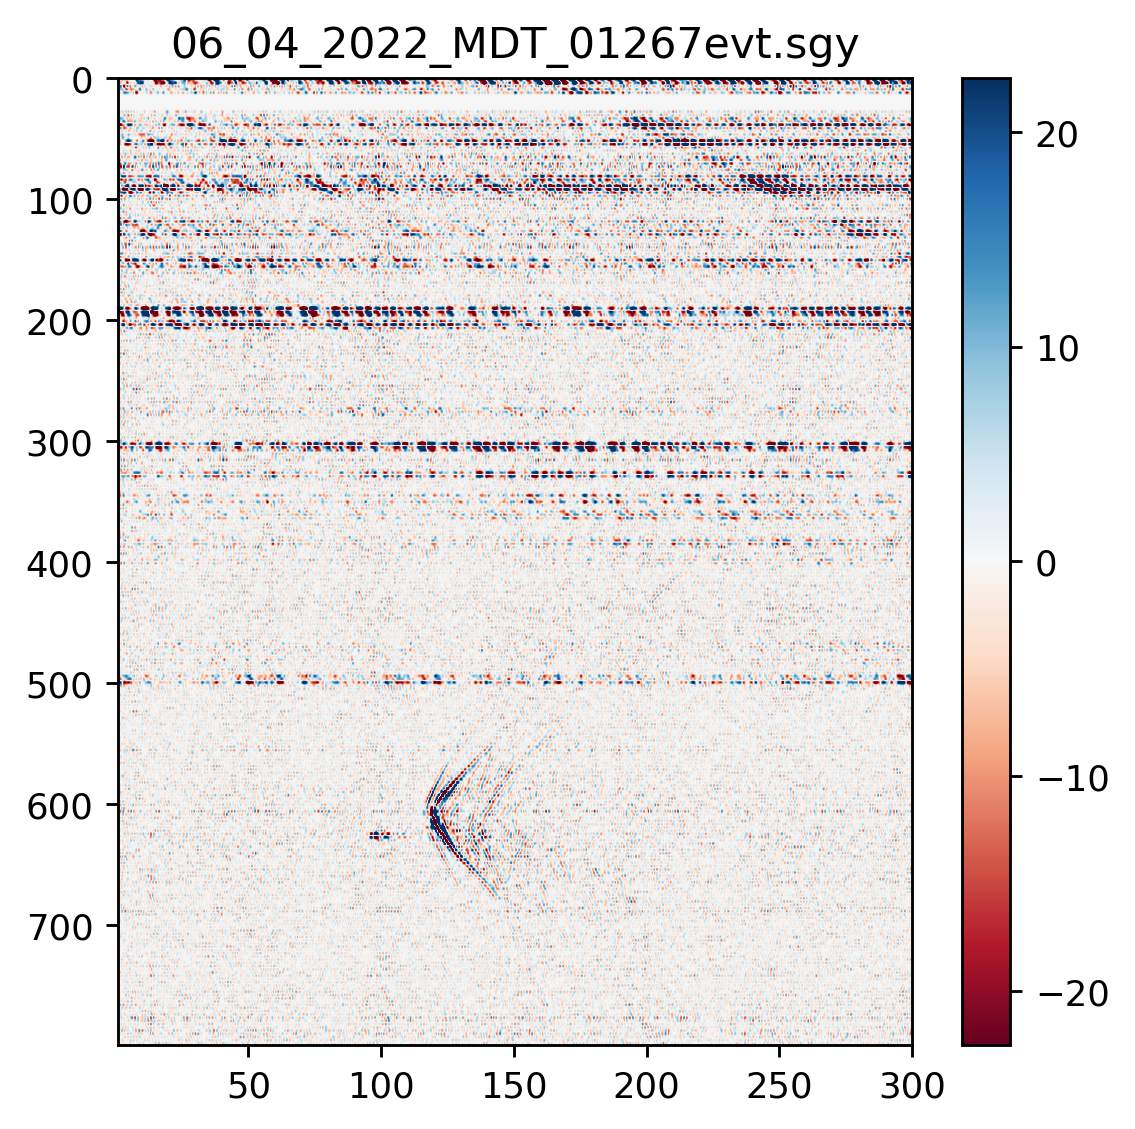

shape of img obj:  ()
shape of transposed data obj (300, 800)
making array
open cv version
min 0.0
max 523.0999603575585
shape of sobelxy (200, 450)


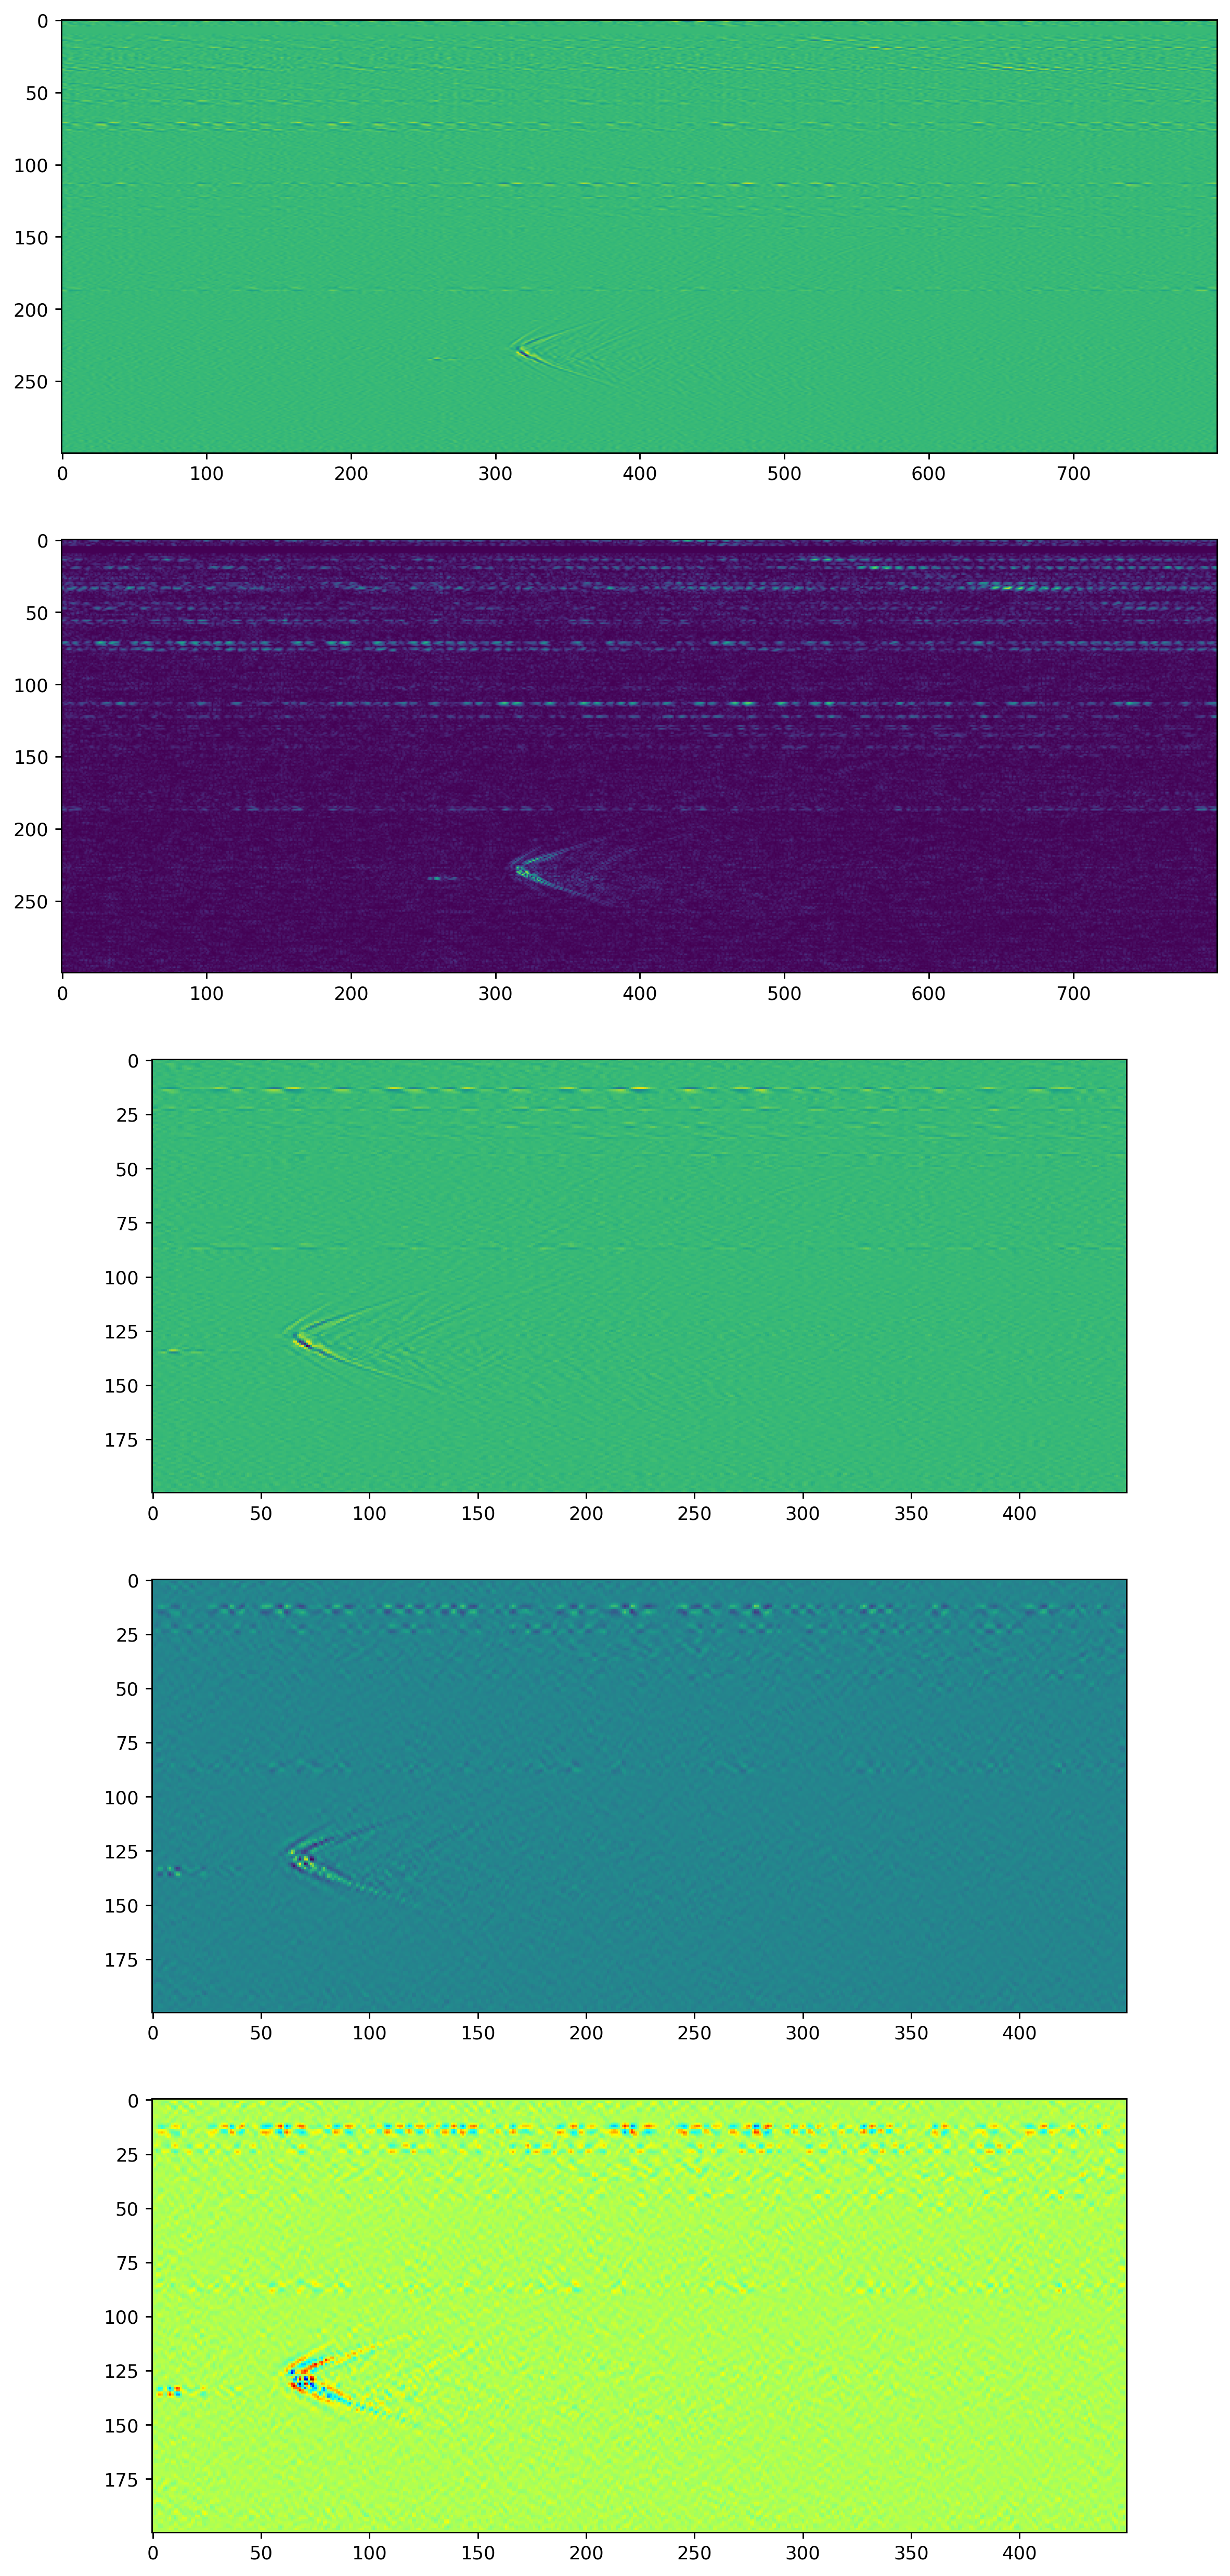

In [2]:

# get current dir

print(os.getcwd())

# change directory to segy data folder

os.chdir(ROOT_DIR + "\\segy\\ABstg06")


print(os.getcwd())

file_path = '06_04_2022_MDT_01290evt.sgy'
file_path = '06_04_2022_MDT_01267evt.sgy'

make_heatmap_overlay(file_path)